In [1]:
import numpy as np
import tensorflow as tf
import cv2
import scipy.io
import pickle
from matplotlib import pyplot as plt

In [2]:
# define os - used for making paths
os = 'linux'
#os = 'windows'

## movie frames

In [3]:
# load input data
if os == 'linux':
    input_data = scipy.io.loadmat('../../data/2010-08-30_fish_movie_frames.mat')
elif os == 'windows':
    input_data = scipy.io.loadmat('../00_data/2010-08-30_fish_movie_frames.mat')

In [4]:
def print_keys(dict):
    keys = list(dict.keys())
    nitems = len(dict.items())
    
    print("\nkeys = ")
    for i in range(nitems):
        print("\"{}\"".format(keys[i]))
        
def print_items(dict):
    items = list(dict.items())
    nitems = len(items)
    
    print("\nitems = ")
    for i in range(nitems):
        print("key #{} = {}".format(i, items[i][0]))
        print("value #{} = {}\n".format(i, items[i][1]))
        
def show_dict(dict):
    nitems = len(dict.items())

    print("type = {0}".format(type(dict)))
    print("number of items = {0}".format(nitems))
    print_keys(dict)
    print_items(dict)
    
    return nitems

In [5]:
# read input data
nitems = show_dict(input_data)

# input data contains 1141 movie frames of fish and plants in a tank

type = <class 'dict'>
number of items = 8

keys = 
"__header__"
"__version__"
"__globals__"
"nframes"
"frames"
"xpixels"
"ypixels"
"plot_example_frame"

items = 
key #0 = __header__
value #0 = b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Dec  5 14:50:17 2011'

key #1 = __version__
value #1 = 1.0

key #2 = __globals__
value #2 = []

key #3 = nframes
value #3 = [[1141]]

key #4 = frames
value #4 = [[[126 169 169 ... 117 111 114]
  [131 145 140 ... 106 108 111]
  [135 135 131 ... 108 114 114]
  ...
  [150 153 169 ... 124 131 134]
  [162 169 167 ... 118 123 135]
  [170 164 167 ... 111 127 133]]

 [[127 171 171 ... 115 111 113]
  [131 146 142 ... 105 106 113]
  [135 135 133 ... 109 114 114]
  ...
  [148 154 170 ... 124 130 134]
  [163 170 167 ... 120 122 135]
  [171 165 167 ... 113 125 133]]

 [[128 170 174 ... 117 111 111]
  [130 147 144 ... 106 106 113]
  [134 135 133 ... 106 114 114]
  ...
  [150 154 170 ... 124 131 134]
  [163 169 167 ... 120 121 134]
  [169 164 169 ... 111 

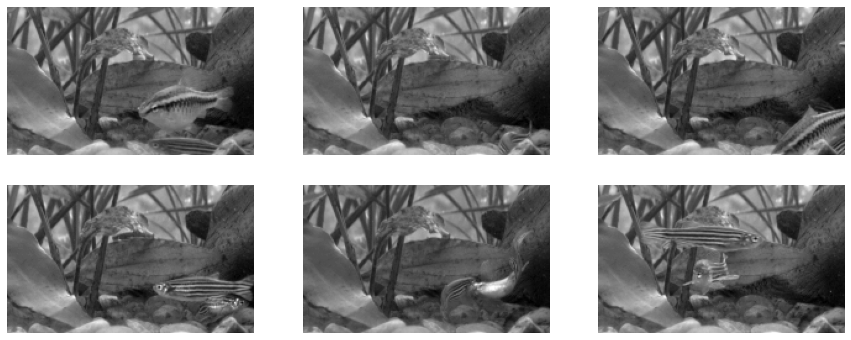

In [6]:
def show_random_frames(frames, nframes, equal = False):
    assert(len(frames) >= nframes)
    
    if equal:
        plt.figure(figsize = (12, 4*nframes//3))
    else:
        plt.figure(figsize = (15, nframes))
    
    for i in range(nframes):
        ind = np.random.randint(0,len(frames))
        plt.subplot(-(nframes//-3),3,i+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")

show_random_frames(input_data['frames'], 6)

## neurons' spike vs. time plots

## denoise frames

In [7]:
# denoise all frames using the bilateral filter
bf_frames = []

for i in range(len(input_data['frames'])):
    # Apply bilateral filter with d = 15,
    # sigmaColor = sigmaSpace = 75.
    bf_frames = bf_frames + [cv2.bilateralFilter(input_data['frames'][i], 15, 20, 75)]
    
f_frames = bf_frames

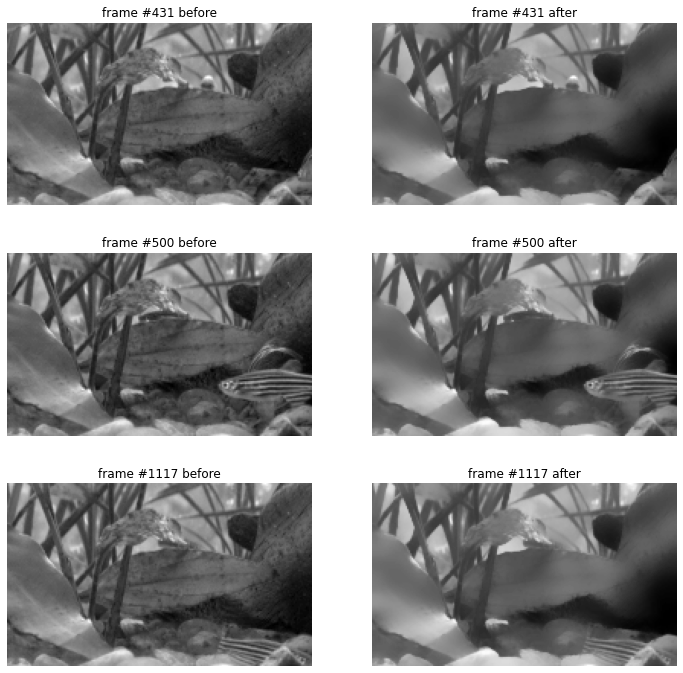

In [8]:
# show unfiltered vs. filtered frames
def show_before_after(unfiltered, filtered, nframes):
    assert(len(unfiltered)==len(filtered))
    assert(len(filtered) >= nframes)
    
    plt.figure(figsize = (12, 4*nframes))
    for i in range(nframes):
        ind = np.random.randint(0,len(filtered))
        
        plt.subplot(nframes,2,2*i+1)
        plt.imshow(unfiltered[ind], cmap='gray')
        plt.title("frame #{} before".format(ind))
        plt.axis("off")
        
        plt.subplot(nframes,2,2*i+2)
        plt.imshow(filtered[ind], cmap='gray')
        plt.title("frame #{} after".format(ind))
        plt.axis("off")
        
show_before_after(input_data['frames'], f_frames, 3)

## feature extraction

we use mobilenet_v2 network which is pre-trained on imagenet dataset.

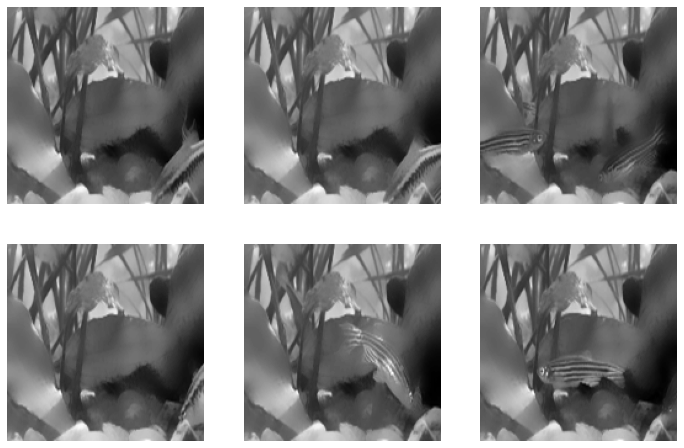

In [9]:
# mobilenet_v2 modle assumes image size (160, 160, 3)
# as a result, we need to rescale images before giving them to the model.

square_frames = np.zeros((len(f_frames),160,160))
for i in range(len(f_frames)):
    square_frames[i] = cv2.resize(f_frames[i], dsize=(160,160), interpolation=cv2.INTER_CUBIC)

show_random_frames(square_frames, 6, equal=True)

In [10]:
# model expects pictures with 3 channels r,g,b
# consequentlly, we need to broadcast our images into three channels

square_frames_3ch = np.broadcast_to(square_frames.reshape(len(square_frames),160,160,1), \
                                    (len(square_frames),160,160,3)).astype(np.int32)

In [11]:
# model expects the images in tf.tensor format; consequently, we convert type of data form np.ndarray to tf.tensor
# moreover, model cannot process large batches; consequently we distribute the whole dataset into 10-frame batches

input_batches = []
num_batches_1 = len(square_frames_3ch)//10
for i in range(num_batches_1):
    input_batches = input_batches + [tf.convert_to_tensor(square_frames_3ch[10*i:10*(i+1)])]
input_batches = input_batches + [tf.convert_to_tensor(square_frames_3ch[10*num_batches_1:])]

In [12]:
# the model assumes pixel values are in [-1,1] while our images have pixel values in [0,255]
# consequently, a preprocessing layer should be added to the network to convert [0,255] interval into [-1,1]

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
# mobilenet_v2 turns each picture batch of size (batch_sz,160,160,3) 
# into feature batch of size (batch_sz,5,5,128)

feature_batches = []

for i in range(num_batches_1+1):
    feature_batches = feature_batches + [base_model(input_batches[i])]

In [16]:
# concatenate all feature batches to form a master feature tensor

features_tensor = feature_batches[0]
for i in range(num_batches_1):
    features_tensor = tf.concat([features_tensor, feature_batches[i+1]], axis=0)

In [17]:
# now we have a tensor of 1141 frames each described by a (5, 5, 1280) feature tensor

print(features_tensor.shape)

(1141, 5, 5, 1280)


In [18]:
# save extracted features to disk
if os == 'linux':
    open_file = open('../../data/features_tensor.pkl', 'wb')
elif os == 'windows':
    open_file = open('../00_data/features_tensor.pkl', 'wb')
    
pickle.dump(features_tensor, open_file)
open_file.close()

In [19]:
# CODE TO OPEN THE FILE LATER:
# if os == 'linux':
#     open_file = open('../../data/features_tensor.pkl', 'rb')
# elif os == 'windows':
#     open_file = open('../00_data/features_tensor.pkl', 'rb')  
# loaded_list = pickle.load(open_file)
# open_file.close()